<a href="https://colab.research.google.com/github/pandu1992/Reinfocement_Learning/blob/main/DQN_Variant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
DQN - Avg Total Revenue: 115221.29
DDQN - Avg Total Revenue: 91797.29
Dueling DQN - Avg Total Revenue: 98560.35
Prioritized Experience Replay - Avg Total Revenue: 100374.89
Noisy DQN - Avg Total Revenue: 97111.65
Rainbow DQN - Avg Total Revenue: 98123.52


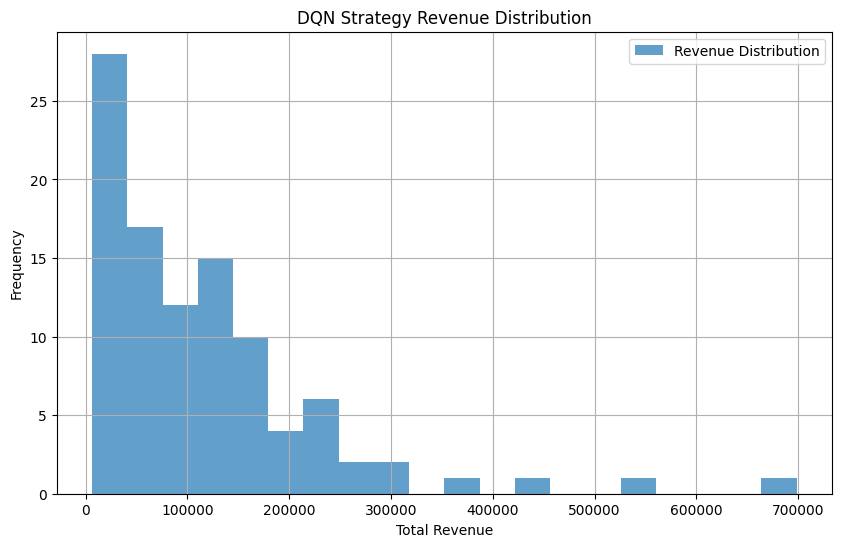

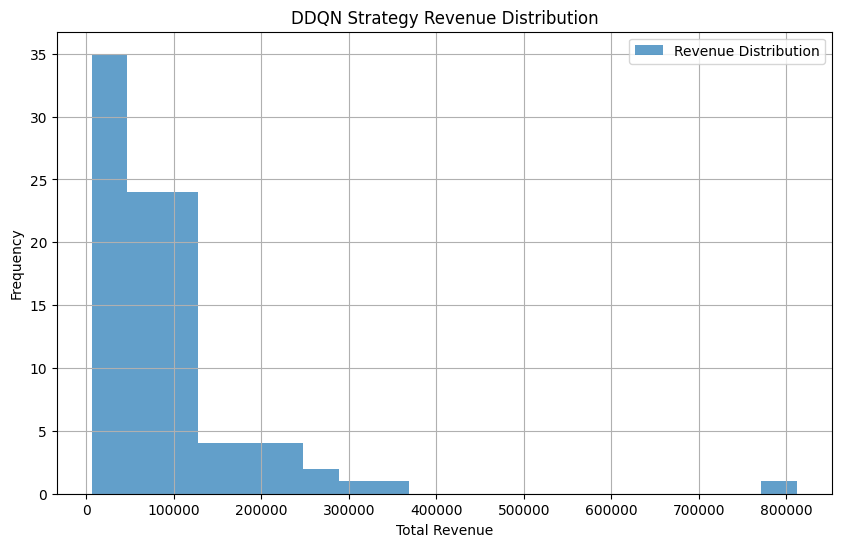

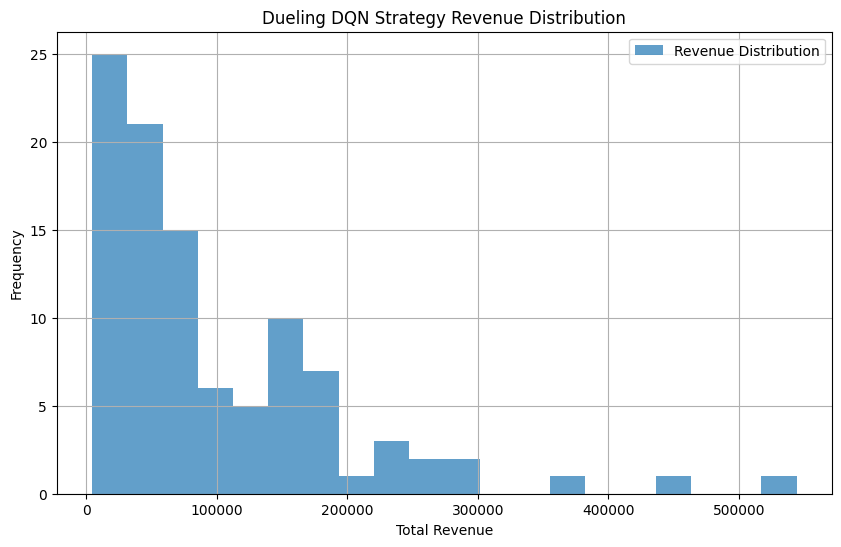

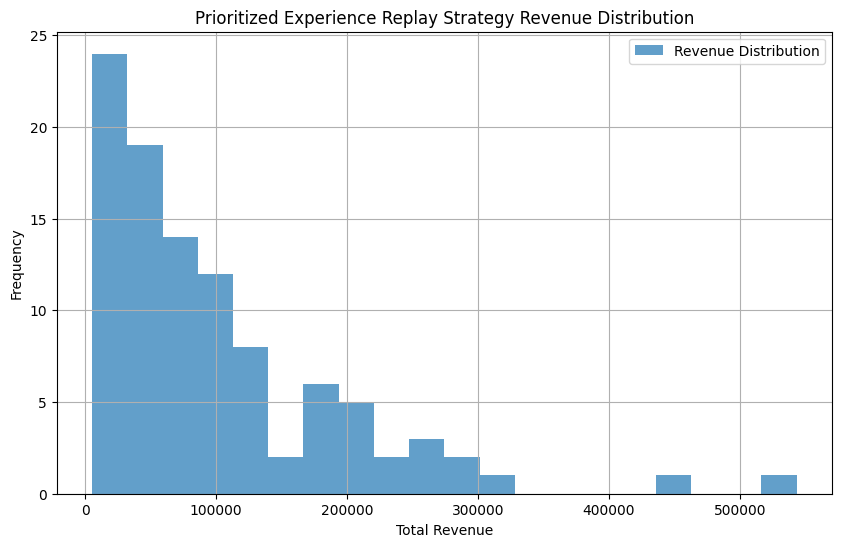

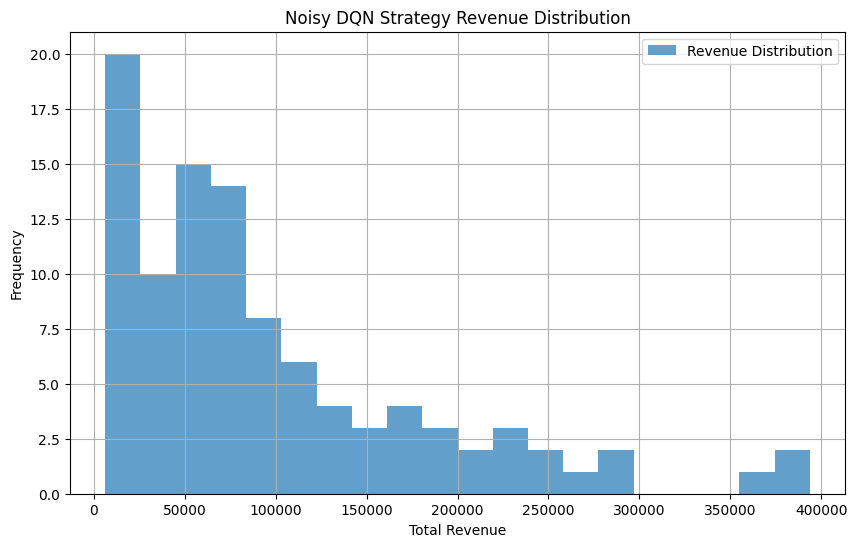

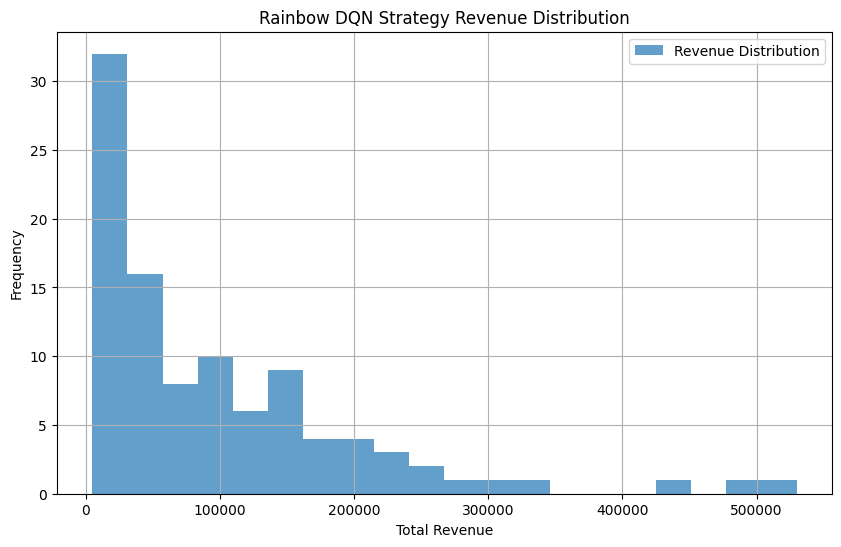

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the hotel pricing environment simulation
class HotelPricingEnvironment:
    def __init__(self, demand_mean=50, demand_std=10):
        self.time_steps = 100
        self.initial_price = 100
        self.price_increment = 10
        self.demand_mean = demand_mean
        self.demand_std = demand_std

    def step(self, action):
        room_price = self.initial_price + action * self.price_increment
        demand = np.random.normal(self.demand_mean, self.demand_std)
        revenue = demand * room_price
        next_state = None
        reward = revenue
        done = False
        if action == 5:
            done = True
        return next_state, reward, done, {}

# Base DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Double DQN (DDQN) agent
class DDQNAgent(DQNAgent):
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                best_action = np.argmax(self.model.predict(next_state)[0])
                target = reward + self.gamma * self.target_model.predict(next_state)[0][best_action]
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Dueling DQN agent
class DuelingDQNAgent(DQNAgent):
    def _build_model(self):
        input_layer = Input(shape=(self.state_size,))
        dense1 = Dense(24, activation='relu')(input_layer)
        dense2 = Dense(24, activation='relu')(dense1)
        value_fc = Dense(24, activation='relu')(dense2)
        value = Dense(1, activation='linear')(value_fc)
        advantage_fc = Dense(24, activation='relu')(dense2)
        advantage = Dense(self.action_size, activation='linear')(advantage_fc)

        def combine_value_advantage(inputs):
            value, advantage = inputs
            return value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))

        q_values = Lambda(combine_value_advantage)([value, advantage])
        model = Model(inputs=input_layer, outputs=q_values)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

# Prioritized Experience Replay agent
class PERAgent(DQNAgent):
    def __init__(self, state_size, action_size):
        super().__init__(state_size, action_size)
        self.priority = deque(maxlen=2000)

    def remember(self, state, action, reward, next_state, done):
        error = abs(reward - np.amax(self.target_model.predict(next_state)[0])) if not done else abs(reward)
        self.memory.append((state, action, reward, next_state, done))
        self.priority.append(error)

    def replay(self, batch_size):
        priorities = np.array(self.priority)
        probabilities = priorities / np.sum(priorities)
        minibatch = random.choices(self.memory, probabilities, k=batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Noisy DQN agent
class NoisyDQNAgent(DQNAgent):
    def _build_model(self):
        input_layer = Input(shape=(self.state_size,))
        dense1 = Dense(24, activation='relu')(input_layer)
        dense2 = Dense(24, activation='relu')(dense1)
        noisy1 = Dense(self.action_size, activation='linear')(dense2)
        model = Model(inputs=input_layer, outputs=noisy1)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        noise = np.random.normal(0, 1, self.action_size)
        return np.argmax(act_values[0] + noise)

# Rainbow DQN agent
class RainbowDQNAgent(PERAgent, DDQNAgent, DuelingDQNAgent, NoisyDQNAgent):
    pass

# Simulate agent function
def simulate_agent(agent_class, demand_mean=50, demand_std=10, episodes=100):
    env = HotelPricingEnvironment(demand_mean, demand_std)
    state_size = 1
    action_size = 10
    agent = agent_class(state_size, action_size)
    batch_size = 32
    total_rewards = []

    for episode in range(episodes):
        state = np.array([[env.initial_price]])
        state = np.reshape(state, [1, state_size])
        episode_rewards = []

        for time_step in range(env.time_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([[env.initial_price]])
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_rewards.append(reward)

            if done:
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        total_rewards.append(np.sum(episode_rewards))

    return total_rewards

# Compare strategies function
def compare_strategies():
    strategies = [DQNAgent, DDQNAgent, DuelingDQNAgent, PERAgent, NoisyDQNAgent, RainbowDQNAgent]
    strategy_names = ["DQN", "DDQN", "Dueling DQN", "Prioritized Experience Replay", "Noisy DQN", "Rainbow DQN"]
    results = {}

    for strategy, name in zip(strategies, strategy_names):
        rewards = simulate_agent(strategy, episodes=100)
        results[name] = rewards

    return results

# Revenue Distribution Visualization
def plot_revenue_distribution(rewards, title):
    plt.figure(figsize=(10, 6))
    plt.hist(rewards, bins=20, alpha=0.7, label='Revenue Distribution')
    plt.xlabel('Total Revenue')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to perform analyses
def main():
    # Compare Strategies
    results = compare_strategies()
    for strategy, rewards in results.items():
        print(f"{strategy} - Avg Total Revenue: {np.mean(rewards):.2f}")

    # Revenue Distribution Visualization
    for strategy, rewards in results.items():
        plot_revenue_distribution(rewards, f'{strategy} Strategy Revenue Distribution')

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step

DQNAgent Sensitivity Analysis:
Demand Mean: 40, Demand Std: 5, Avg Total Revenue: 75150.89
Demand Mean: 40, Demand Std: 10, Avg Total Revenue: 52543.46
Demand Mean: 40, Demand Std: 15, Avg Total Revenue: 59520.72
Demand Mean: 50, Demand Std: 5, Avg Total Revenue: 84456.15
Demand Mean: 50, Demand Std: 10, Avg Total Revenue: 61494.50
Demand Mean: 50, Demand Std: 15, Avg Total Revenue: 86702.26
Demand Mean: 60, Demand Std: 5, Avg Total Revenue: 79443.88
Demand Mean: 60, Demand Std: 10, Avg Total Revenue: 84226.06
Demand Mean: 60, Demand Std: 15, Avg Total Revenue: 68345.39

DDQNAgent Sensitivity Analysis:
Demand Mean: 40, Demand Std: 5, Avg Total Revenue: 92278.76
Demand Mean: 40, Demand Std: 10, Avg Total Revenue: 61830.96
Demand Mean: 40, Demand Std: 15, Avg Total Revenue: 57311.38
Demand Mean: 50, Demand Std: 5, Avg Total Revenue: 79029.19
Demand Mean: 50, Demand Std: 10, Avg Total R

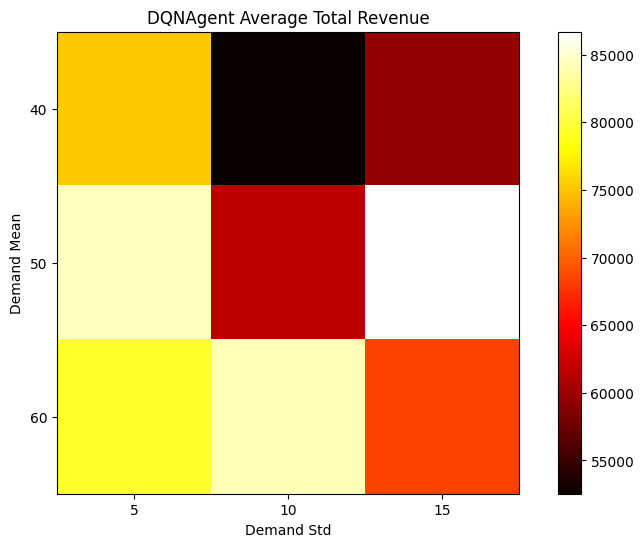

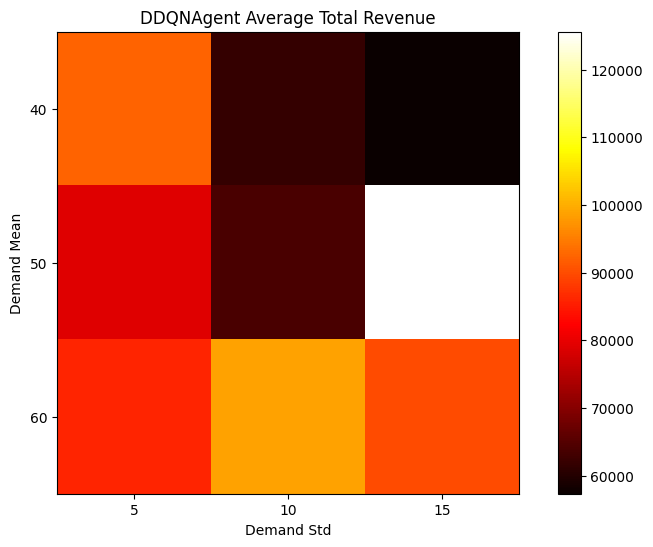

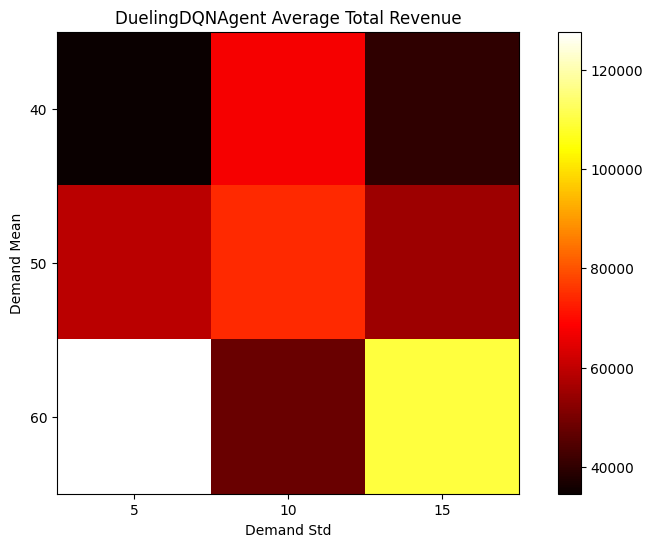

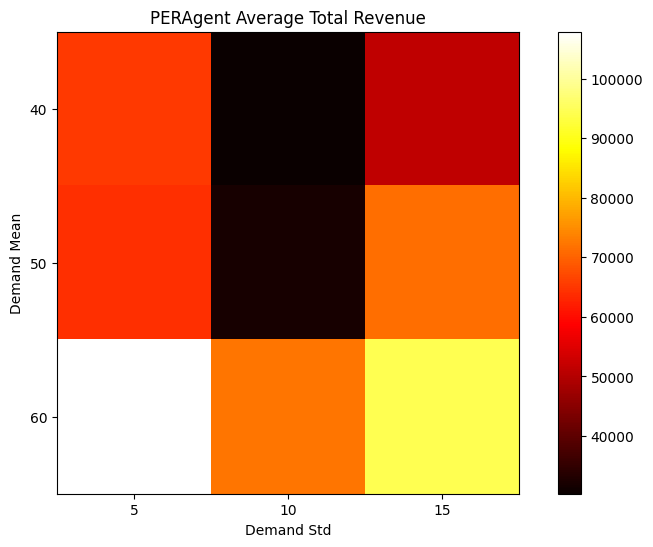

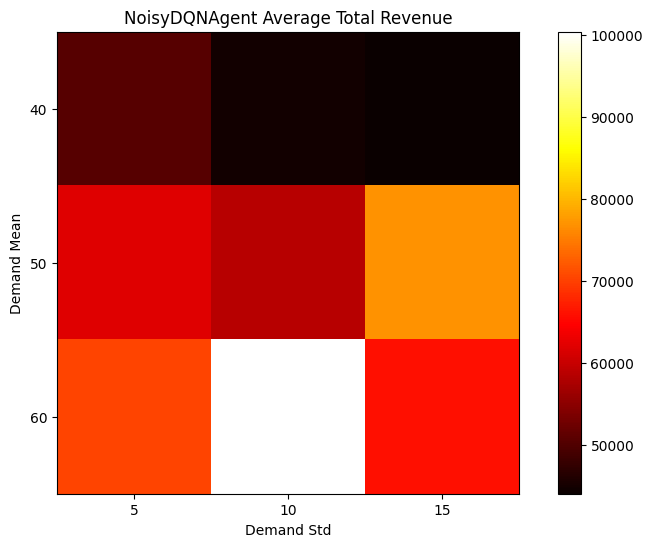

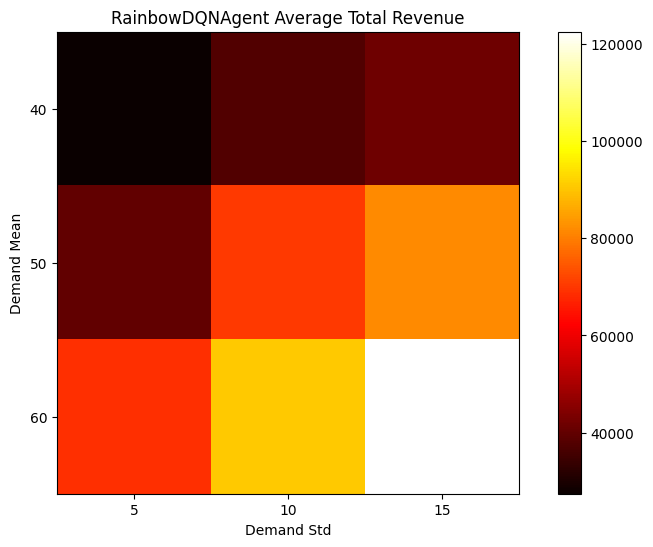

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the hotel pricing environment simulation
class HotelPricingEnvironment:
    def __init__(self, demand_mean=50, demand_std=10):
        self.time_steps = 100
        self.initial_price = 100
        self.price_increment = 10
        self.demand_mean = demand_mean
        self.demand_std = demand_std

    def step(self, action):
        room_price = self.initial_price + action * self.price_increment
        demand = np.random.normal(self.demand_mean, self.demand_std)
        revenue = demand * room_price
        next_state = None
        reward = revenue
        done = False
        if action == 5:
            done = True
        return next_state, reward, done, {}

# Base DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Double DQN (DDQN) agent
class DDQNAgent(DQNAgent):
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                best_action = np.argmax(self.model.predict(next_state)[0])
                target = reward + self.gamma * self.target_model.predict(next_state)[0][best_action]
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Dueling DQN agent
class DuelingDQNAgent(DQNAgent):
    def _build_model(self):
        input_layer = Input(shape=(self.state_size,))
        dense1 = Dense(24, activation='relu')(input_layer)
        dense2 = Dense(24, activation='relu')(dense1)
        value_fc = Dense(24, activation='relu')(dense2)
        value = Dense(1, activation='linear')(value_fc)
        advantage_fc = Dense(24, activation='relu')(dense2)
        advantage = Dense(self.action_size, activation='linear')(advantage_fc)

        def combine_value_advantage(inputs):
            value, advantage = inputs
            return value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))

        q_values = Lambda(combine_value_advantage)([value, advantage])
        model = Model(inputs=input_layer, outputs=q_values)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

# Prioritized Experience Replay agent
class PERAgent(DQNAgent):
    def __init__(self, state_size, action_size):
        super().__init__(state_size, action_size)
        self.priority = deque(maxlen=2000)

    def remember(self, state, action, reward, next_state, done):
        error = abs(reward - np.amax(self.target_model.predict(next_state)[0])) if not done else abs(reward)
        self.memory.append((state, action, reward, next_state, done))
        self.priority.append(error)

    def replay(self, batch_size):
        priorities = np.array(self.priority)
        probabilities = priorities / np.sum(priorities)
        minibatch = random.choices(self.memory, probabilities, k=batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Noisy DQN agent
class NoisyDQNAgent(DQNAgent):
    def _build_model(self):
        input_layer = Input(shape=(self.state_size,))
        dense1 = Dense(24, activation='relu')(input_layer)
        dense2 = Dense(24, activation='relu')(dense1)
        noisy1 = Dense(self.action_size, activation='linear')(dense2)
        model = Model(inputs=input_layer, outputs=noisy1)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        noise = np.random.normal(0, 1, self.action_size)
        return np.argmax(act_values[0] + noise)

# Rainbow DQN agent
class RainbowDQNAgent(PERAgent, DDQNAgent, DuelingDQNAgent, NoisyDQNAgent):
    pass

# Simulate agent function
def simulate_agent(agent_class, demand_mean=50, demand_std=10, episodes=100):
    env = HotelPricingEnvironment(demand_mean, demand_std)
    state_size = 1
    action_size = 10
    agent = agent_class(state_size, action_size)
    batch_size = 32
    total_rewards = []

    for episode in range(episodes):
        state = np.array([[env.initial_price]])
        state = np.reshape(state, [1, state_size])
        episode_rewards = []

        for time_step in range(env.time_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([[env.initial_price]])
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_rewards.append(reward)

            if done:
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        total_rewards.append(np.sum(episode_rewards))

    return total_rewards

# Sensitivity Analysis
def sensitivity_analysis(agent_classes, means, stds):
    results = {}
    for agent_class in agent_classes:
        agent_name = agent_class.__name__
        results[agent_name] = {}
        for mean in means:
            for std in stds:
                rewards = simulate_agent(agent_class, demand_mean=mean, demand_std=std, episodes=10)
                results[agent_name][(mean, std)] = np.mean(rewards)
    return results

# Visualization
def plot_sensitivity_results(sensitivity_results):
    for agent, results in sensitivity_results.items():
        means = sorted(set(k[0] for k in results.keys()))
        stds = sorted(set(k[1] for k in results.keys()))
        heatmap = np.zeros((len(means), len(stds)))

        for (mean, std), avg_reward in results.items():
            i = means.index(mean)
            j = stds.index(std)
            heatmap[i, j] = avg_reward

        plt.figure(figsize=(10, 6))
        plt.imshow(heatmap, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.xticks(ticks=range(len(stds)), labels=stds)
        plt.yticks(ticks=range(len(means)), labels=means)
        plt.xlabel('Demand Std')
        plt.ylabel('Demand Mean')
        plt.title(f'{agent} Average Total Revenue')
        plt.show()

# Statistical Analysis
def perform_anova(sensitivity_results):
    data = []
    for agent, results in sensitivity_results.items():
        for (mean, std), avg_reward in results.items():
            data.append([agent, mean, std, avg_reward])

    df = pd.DataFrame(data, columns=['Agent', 'Demand Mean', 'Demand Std', 'Avg Reward'])
    formula = 'Avg Reward ~ C(Agent) + C(Demand Mean) + C(Demand Std) + C(Agent):C(Demand Mean) + C(Agent):C(Demand Std)'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

# Robustness Analysis
def calculate_robustness(sensitivity_results):
    for agent, results in sensitivity_results.items():
        rewards = list(results.values())
        robustness = np.std(rewards)
        print(f"{agent} Robustness (std of total revenue): {robustness:.2f}")

# Main function to perform analyses
def main():
    agent_classes = [DQNAgent, DDQNAgent, DuelingDQNAgent, PERAgent, NoisyDQNAgent, RainbowDQNAgent]
    means = [40, 50, 60]
    stds = [5, 10, 15]

    # Sensitivity Analysis
    sensitivity_results = sensitivity_analysis(agent_classes, means, stds)

    for agent, results in sensitivity_results.items():
        print(f"\n{agent} Sensitivity Analysis:")
        for params, avg_reward in results.items():
            mean, std = params
            print(f"Demand Mean: {mean}, Demand Std: {std}, Avg Total Revenue: {avg_reward:.2f}")

    # Visualization
    plot_sensitivity_results(sensitivity_results)

    # Statistical Analysis
    perform_anova(sensitivity_results)

    # Robustness Analysis
    calculate_robustness(sensitivity_results)

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step

DQNAgent Sensitivity Analysis:
Demand Mean: 40, Demand Std: 5, Avg Total Revenue: 76610.55
Demand Mean: 40, Demand Std: 10, Avg Total Revenue: 93597.26
Demand Mean: 40, Demand Std: 15, Avg Total Revenue: 105197.51
Demand Mean: 50, Demand Std: 5, Avg Total Revenue: 70412.01
Demand Mean: 50, Demand Std: 10, Avg Total Revenue: 70099.17
Demand Mean: 50, Demand Std: 15, Avg Total Revenue: 71765.58
Demand Mean: 60, Demand Std: 5, Avg Total Revenue: 94369.26
Demand Mean: 60, Demand Std: 10, Avg Total Revenue: 59571.53
Demand Mean: 60, Demand Std: 15, Avg Total Revenue: 85787.79

DDQNAgent Sensitivity Analysis:
Demand Mean: 40, Demand Std: 5, Avg Total Revenue: 58083.29
Demand Mean: 40, Demand Std: 10, Avg Total Revenue: 63193.40
Demand Mean: 40, Demand Std: 15, Avg Total Revenue: 37755.48
Demand Mean: 50, Demand Std: 5, Avg Total Revenue: 72496.46
Demand Mean: 50, Demand Std: 10, Avg Total 

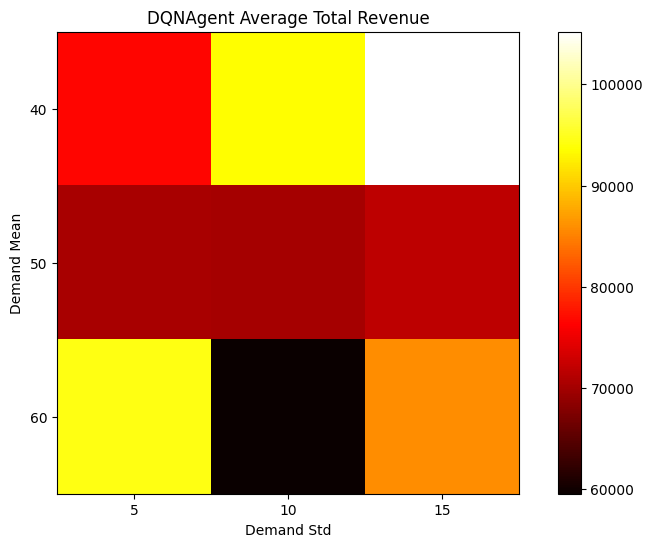

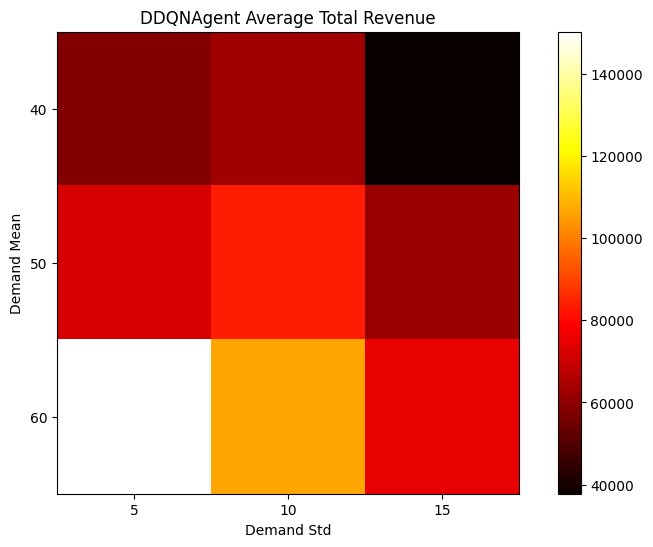

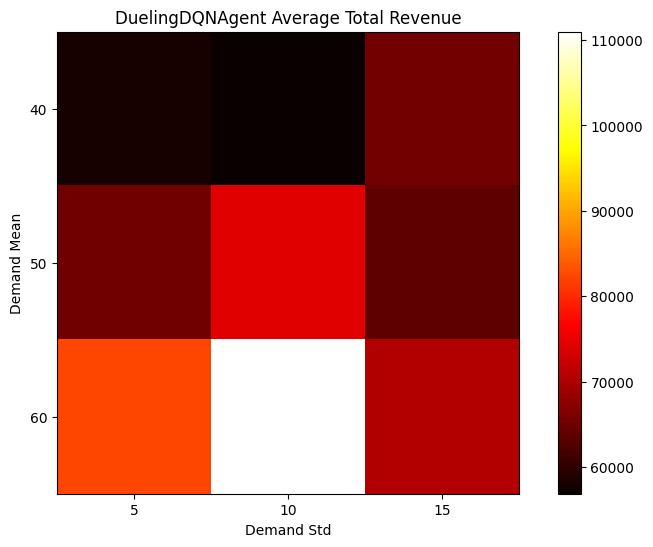

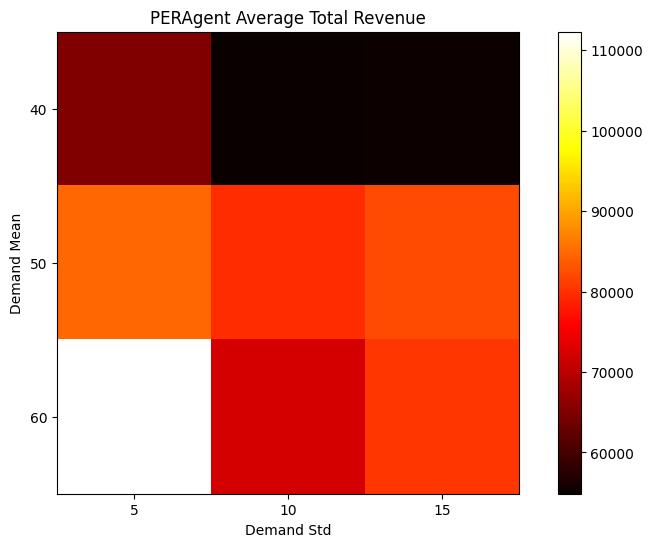

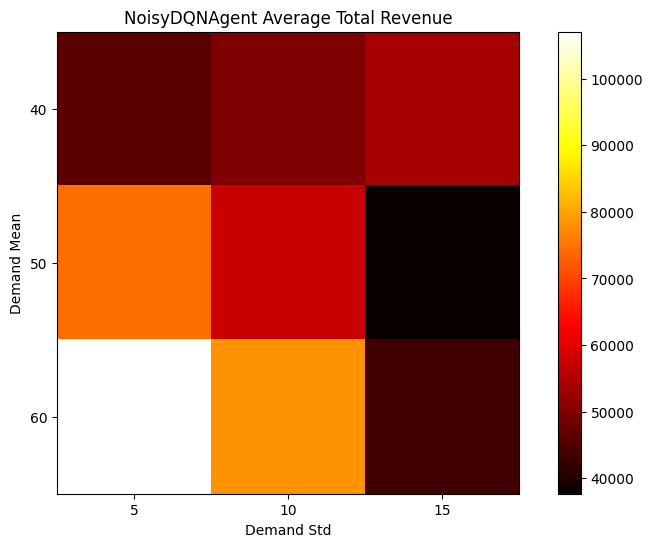

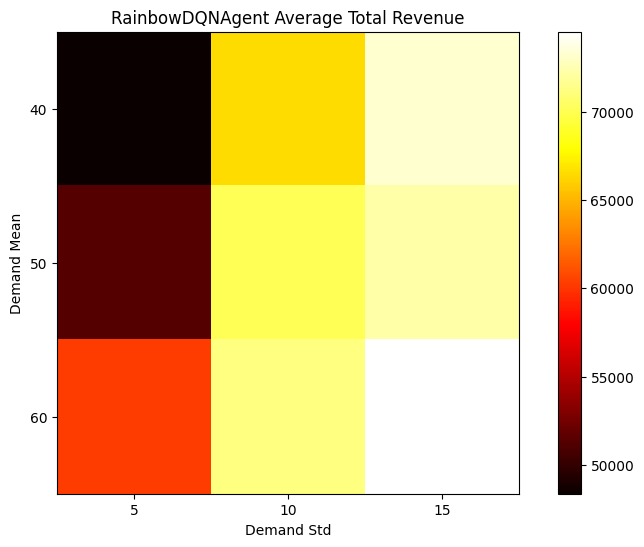

                               sum_sq    df          F    PR(>F)
C(Agent)                 2.807063e+09   5.0   2.937846  0.033028
C(Demand_Mean)           4.914201e+09   2.0  12.857894  0.000160
C(Demand_Std)            7.997692e+08   2.0   2.092578  0.145308
C(Agent):C(Demand_Mean)  4.872725e+09  10.0   2.549874  0.029333
C(Agent):C(Demand_Std)   4.509352e+09  10.0   2.359723  0.041311
Residual                 4.586320e+09  24.0        NaN       NaN
DQNAgent Robustness (std of total revenue): 13905.41
DDQNAgent Robustness (std of total revenue): 30971.87
DuelingDQNAgent Robustness (std of total revenue): 15679.74
PERAgent Robustness (std of total revenue): 16565.43
NoisyDQNAgent Robustness (std of total revenue): 20717.81
RainbowDQNAgent Robustness (std of total revenue): 9209.61


In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the hotel pricing environment simulation
class HotelPricingEnvironment:
    def __init__(self, demand_mean=50, demand_std=10):
        self.time_steps = 100
        self.initial_price = 100
        self.price_increment = 10
        self.demand_mean = demand_mean
        self.demand_std = demand_std

    def step(self, action):
        room_price = self.initial_price + action * self.price_increment
        demand = np.random.normal(self.demand_mean, self.demand_std)
        revenue = demand * room_price
        next_state = None
        reward = revenue
        done = False
        if action == 5:
            done = True
        return next_state, reward, done, {}

# Base DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Double DQN (DDQN) agent
class DDQNAgent(DQNAgent):
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                best_action = np.argmax(self.model.predict(next_state)[0])
                target = reward + self.gamma * self.target_model.predict(next_state)[0][best_action]
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Dueling DQN agent
class DuelingDQNAgent(DQNAgent):
    def _build_model(self):
        input_layer = Input(shape=(self.state_size,))
        dense1 = Dense(24, activation='relu')(input_layer)
        dense2 = Dense(24, activation='relu')(dense1)
        value_fc = Dense(24, activation='relu')(dense2)
        value = Dense(1, activation='linear')(value_fc)
        advantage_fc = Dense(24, activation='relu')(dense2)
        advantage = Dense(self.action_size, activation='linear')(advantage_fc)

        def combine_value_advantage(inputs):
            value, advantage = inputs
            return value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))

        q_values = Lambda(combine_value_advantage)([value, advantage])
        model = Model(inputs=input_layer, outputs=q_values)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

# Prioritized Experience Replay agent
class PERAgent(DQNAgent):
    def __init__(self, state_size, action_size):
        super().__init__(state_size, action_size)
        self.priority = deque(maxlen=2000)

    def remember(self, state, action, reward, next_state, done):
        error = abs(reward - np.amax(self.target_model.predict(next_state)[0])) if not done else abs(reward)
        self.memory.append((state, action, reward, next_state, done))
        self.priority.append(error)

    def replay(self, batch_size):
        priorities = np.array(self.priority)
        probabilities = priorities / np.sum(priorities)
        minibatch = random.choices(self.memory, probabilities, k=batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Noisy DQN agent
class NoisyDQNAgent(DQNAgent):
    def _build_model(self):
        input_layer = Input(shape=(self.state_size,))
        dense1 = Dense(24, activation='relu')(input_layer)
        dense2 = Dense(24, activation='relu')(dense1)
        noisy1 = Dense(self.action_size, activation='linear')(dense2)
        model = Model(inputs=input_layer, outputs=noisy1)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        noise = np.random.normal(0, 1, self.action_size)
        return np.argmax(act_values[0] + noise)

# Rainbow DQN agent
class RainbowDQNAgent(PERAgent, DDQNAgent, DuelingDQNAgent, NoisyDQNAgent):
    pass

# Simulate agent function
def simulate_agent(agent_class, demand_mean=50, demand_std=10, episodes=100):
    env = HotelPricingEnvironment(demand_mean, demand_std)
    state_size = 1
    action_size = 10
    agent = agent_class(state_size, action_size)
    batch_size = 32
    total_rewards = []

    for episode in range(episodes):
        state = np.array([[env.initial_price]])
        state = np.reshape(state, [1, state_size])
        episode_rewards = []

        for time_step in range(env.time_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([[env.initial_price]])
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_rewards.append(reward)

            if done:
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        total_rewards.append(np.sum(episode_rewards))

    return total_rewards

# Sensitivity Analysis
def sensitivity_analysis(agent_classes, means, stds):
    results = {}
    for agent_class in agent_classes:
        agent_name = agent_class.__name__
        results[agent_name] = {}
        for mean in means:
            for std in stds:
                rewards = simulate_agent(agent_class, demand_mean=mean, demand_std=std, episodes=10)
                results[agent_name][(mean, std)] = np.mean(rewards)
    return results

# Visualization
def plot_sensitivity_results(sensitivity_results):
    for agent, results in sensitivity_results.items():
        means = sorted(set(k[0] for k in results.keys()))
        stds = sorted(set(k[1] for k in results.keys()))
        heatmap = np.zeros((len(means), len(stds)))

        for (mean, std), avg_reward in results.items():
            i = means.index(mean)
            j = stds.index(std)
            heatmap[i, j] = avg_reward

        plt.figure(figsize=(10, 6))
        plt.imshow(heatmap, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.xticks(ticks=range(len(stds)), labels=stds)
        plt.yticks(ticks=range(len(means)), labels=means)
        plt.xlabel('Demand Std')
        plt.ylabel('Demand Mean')
        plt.title(f'{agent} Average Total Revenue')
        plt.show()

# Statistical Analysis
def perform_anova(sensitivity_results):
    data = []
    for agent, results in sensitivity_results.items():
        for (mean, std), avg_reward in results.items():
            data.append([agent, mean, std, avg_reward])

    df = pd.DataFrame(data, columns=['Agent', 'Demand_Mean', 'Demand_Std', 'Avg_Reward'])
    formula = 'Avg_Reward ~ C(Agent) + C(Demand_Mean) + C(Demand_Std) + C(Agent):C(Demand_Mean) + C(Agent):C(Demand_Std)'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

# Robustness Analysis
def calculate_robustness(sensitivity_results):
    for agent, results in sensitivity_results.items():
        rewards = list(results.values())
        robustness = np.std(rewards)
        print(f"{agent} Robustness (std of total revenue): {robustness:.2f}")

# Main function to perform analyses
def main():
    agent_classes = [DQNAgent, DDQNAgent, DuelingDQNAgent, PERAgent, NoisyDQNAgent, RainbowDQNAgent]
    means = [40, 50, 60]
    stds = [5, 10, 15]

    # Sensitivity Analysis
    sensitivity_results = sensitivity_analysis(agent_classes, means, stds)

    for agent, results in sensitivity_results.items():
        print(f"\n{agent} Sensitivity Analysis:")
        for params, avg_reward in results.items():
            mean, std = params
            print(f"Demand Mean: {mean}, Demand Std: {std}, Avg Total Revenue: {avg_reward:.2f}")

    # Visualization
    plot_sensitivity_results(sensitivity_results)

    # Statistical Analysis
    perform_anova(sensitivity_results)

    # Robustness Analysis
    calculate_robustness(sensitivity_results)

if __name__ == "__main__":
    main()
